# Polarization reconstruction with neutrinos

### Dec 16, 2020

## Code

In [2]:
import sys
import csv
# sys.path.insert(0,"/users/PCON0003/cond0068/.local/lib/python3.7/")
sys.path.append("/users/PAS0654/osu8354/ARA_cvmfs/root_build/lib/") # go to parent dir
sys.path.append("/users/PCON0003/cond0068/.local/lib/python3.7/site-packages/")
# sys.path.append("/users/PCON0003/cond0068/pyrex_sims/fromBen/thesis_work/pyrex-custom/analysis/custom/analysis/")
import ROOT
import math
import numpy as np
from ROOT import TH1D,TF1, gRandom, gPad, gStyle
import matplotlib as mpl
import matplotlib.pyplot as plt
from ROOT import TChain, TSelector, TTree
import os
import matplotlib.colors as mcolors
import scipy
from matplotlib.colors import LogNorm
import pandas as pd
import pyrex
import seaborn as sns
%matplotlib inline
sys.path.insert(1, "/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes")
import deDisperse_util as util
from pyrex.internal_functions import normalize
my_path_plots = os.path.abspath("./plots/")
import pyrex.custom.ara as ara


Welcome to JupyROOT 6.18/04


In [3]:
# mpl.use('agg') 
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True
mpl.rcParams['mathtext.rm'] = 'Times New Roman'
mpl.rcParams['mathtext.it'] = 'Times New Roman:italic'
mpl.rcParams['mathtext.bf'] = 'Times New Roman:bold'

mpl.rc('font', family='serif', size=12)
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['xtick.major.size'] = 5
mpl.rcParams['ytick.major.size'] = 5

mpl.rcParams['axes.titlesize'] = 18
mpl.rcParams['axes.labelsize'] = 18
# mpl.rc('font', size=16)
mpl.rc('axes', titlesize=20)

current_palette = sns.color_palette('colorblind', 10)
import warnings
warnings.filterwarnings("ignore")


## Events debugging

In [4]:
appended_data = []
import os
for filename in os.listdir("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/noMag/"):#Loop over desired directory
        if (filename.startswith("pol_quant_noiseless_")): #extension, .root in this case
            name = os.path.join("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/noMag/", str(filename))
            data = pd.read_pickle(name)
            appended_data.append(data)
recoNu = pd.concat(appended_data)     
# recoNu = pd.read_pickle("/users/PAS0654/osu8354/ARA_cvmfs/source/AraRoot/analysis/ARA_analysis/CenA_sourceSearch/Stokes/debug/pol_quant_noiseless.pkl")
recoNu = recoNu.loc[recoNu.rmsV>50]
recoNu = recoNu.loc[recoNu.rmsV<1400]
recoNu = recoNu.loc[recoNu.rmsH>50]
recoNu = recoNu.loc[recoNu.rmsH<1400]
# recoNu = recoNu.loc[recoNu.theta_reco<np.pi/2+0.2]
# recoNu = recoNu.loc[recoNu.weight>1E-2]


array2 = []
R_True = []
R_Reco = []
propVec = []
dot = []
for i in recoNu.itertuples(): 
    thetaHat = np.array([np.cos(i.theta_reco)*np.cos(i.phi_reco), np.cos(i.theta_reco)*np.sin(i.phi_reco), -np.sin(i.theta_reco)])
    phiHat = np.array([-np.sin(i.phi_reco), np.cos(i.phi_reco),0])
    R_Reco.append(np.sqrt(i.powerH/i.powerV))
    R = np.dot(i.PolTrue,phiHat)/(np.dot(i.PolTrue,thetaHat))
    R_True.append(R)
    array2.append(util.PolVectorRecoPower_debug(i.powerV,i.powerH, i.theta_reco, i.phi_reco,np.sign(R)))
    propVec = np.array([np.sin(i.theta_reco)*np.cos(i.phi_reco),np.sin(i.theta_reco)*np.sin(i.phi_reco),np.cos(i.theta_reco)])
    dot.append(np.dot(propVec,i.PolTrue))
recoNu["PolReco2"] = array2
# recoNu["PolReco2"] = util.PolVectorReco(recoNu.maxV, recoNu.maxH, recoNu.theta_reco,recoNu.phi_reco)

recoNu["R_True"] = R_True
recoNu["R_Reco"] = R_Reco
recoNu["dotProd"] = dot

# recoNu = recoNu.loc[abs(recoNu.dotProd)<0.001]
recoNu = recoNu.loc[abs(np.degrees(recoNu.view_ang)-56.037)<5]


Px_true = np.array([element[0] for element in recoNu.PolTrue])
Py_true = np.array([element[1] for element in recoNu.PolTrue])
Pz_true = np.array([element[2] for element in recoNu.PolTrue])

Px_reco = np.array([element[0] for element in recoNu.PolReco2])
Py_reco = np.array([element[1] for element in recoNu.PolReco2])
Pz_reco = np.array([element[2] for element in recoNu.PolReco2])


thetaPol_true = np.degrees(np.arccos(abs(Pz_true)))
thetaPol_reco = np.degrees(np.arccos(abs(Pz_reco)))
phiPol_true = np.degrees(np.arctan2(abs(Py_true),abs(Px_true)))
phiPol_reco = np.degrees(np.arctan2(abs(Py_reco),abs(Px_reco)))

recoNu["delta"] = thetaPol_reco-thetaPol_true
recoNu["deltaPhi"] = phiPol_reco-phiPol_true



delta = thetaPol_reco-thetaPol_true
deltaPhi = phiPol_reco-phiPol_true

# delta = delta[~np.isnan(delta)]

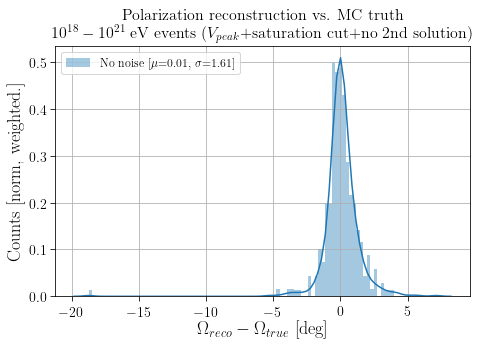

In [45]:
plt.figure(figsize=(7,5))
# plt.hist(recoNu.AngStokes-np.degrees(np.arccos(abs(recoNu.pol_z))), bins=100, density=False, alpha=1);
delta_mean = np.ma.average(delta,weights=recoNu.weight)
variance = np.dot(recoNu.weight, (delta - delta_mean) ** 2) / recoNu.weight.sum()
delta_std = np.sqrt(variance)

sns.distplot(delta, bins=100,hist_kws={'weights': recoNu.weight},norm_hist=False,label = "No noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\Omega_{reco}-\Omega_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm, weighted.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events ($V_{peak}$+saturation cut+no 2nd solution)", fontsize=16)
# plt.xlim(-0.05,0.05)
# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_Cuts_noAbs.png', dpi=250)


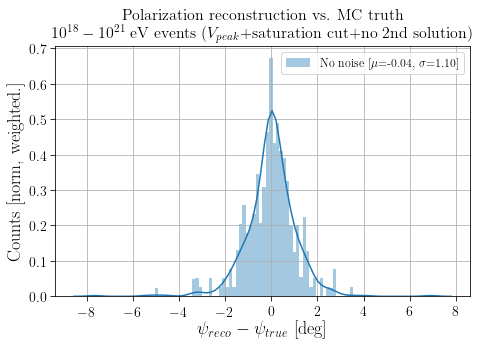

In [46]:
plt.figure(figsize=(7,5))
# plt.hist(recoNu.AngStokes-np.degrees(np.arccos(abs(recoNu.pol_z))), bins=100, density=False, alpha=1);
delta_mean = np.ma.average(deltaPhi,weights=recoNu.weight)
variance = np.dot(recoNu.weight, (deltaPhi - delta_mean) ** 2) / recoNu.weight.sum()
delta_std = np.sqrt(variance)
sns.distplot(deltaPhi, hist_kws={'weights': recoNu.weight},bins=100,label = "No noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

# delta_std = recoNu_noise.deltaTheta.std()
# delta_mean = recoNu_noise.deltaTheta.mean()
# plt.hist(recoNu_noise.deltaTheta, bins=500, density=True, alpha=0.5, color="C1",label = "W/noise [$\mu$=%0.2f, $\sigma$=%0.2f]"%(delta_mean, delta_std));

plt.xlabel("$\psi_{reco}-\psi_{true}$ [deg]")
# plt.xlabel("$\\theta$")
plt.ylabel('Counts [norm, weighted.]')
# plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events (no cuts)")
plt.title("Polarization reconstruction vs. MC truth \n $10^{18}-10^{21}$ eV events ($V_{peak}$+saturation cut+no 2nd solution)",fontsize=16)

# plt.yscale("log")
# mplcyberpunk.add_glow_effects()
# plt.yscale('log')
plt.grid()
plt.legend()
plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_AraSim_Cuts.png', dpi=250)


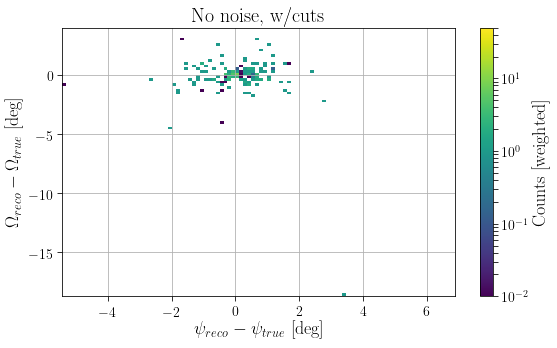

In [42]:
plt.figure(figsize=(8,5))
plt.hist2d(deltaPhi,delta, bins=100, normed=False,norm=mpl.colors.LogNorm(vmin=1E-2,vmax=50),weights=recoNu.weight);
# plt.hist2d(90-recoNu_noise.AngStokes,recoNu_noise.AngStokes-recoNu_noise.theta_pol, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [weighted]")
plt.ylabel("$\Omega_{reco}-\Omega_{true}$ [deg]")
plt.xlabel("$\psi_{reco}-\psi_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()
# plt.xlim(-5,5)
# plt.ylim(-5,5)

# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_Cuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsReco_AraSim_noiseless_noCuts.png', dpi=150)

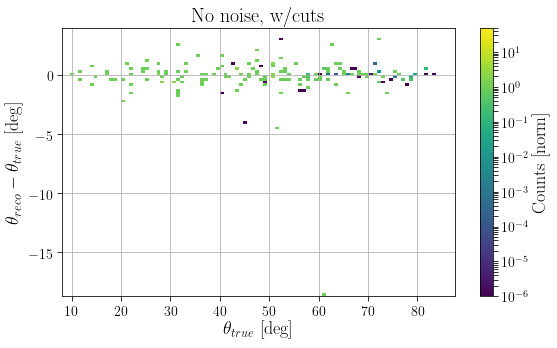

In [43]:
plt.figure(figsize=(8,5))
plt.hist2d(thetaPol_true,delta, bins=100, normed=False,norm=mpl.colors.LogNorm(vmin=1E-6,vmax=50),weights=recoNu.weight);
# plt.hist2d(90-recoNu_noise.AngStokes,recoNu_noise.AngStokes-recoNu_noise.theta_pol, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [norm]")
plt.xlabel("$\\theta_{true}$ [deg]")
plt.ylabel("$\\theta_{reco}-\\theta_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()
# plt.xlim(0,90)
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_Cuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsReco_AraSim_noiseless_noCuts.png', dpi=150)

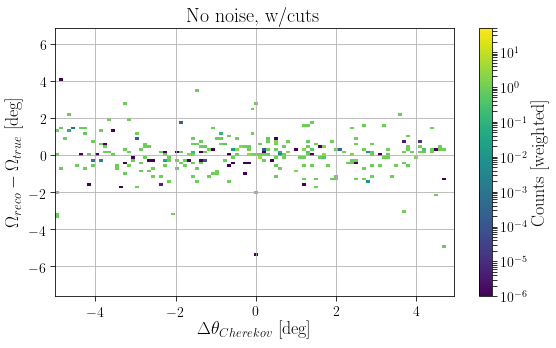

In [25]:
plt.figure(figsize=(8,5))
plt.hist2d(np.degrees(recoNu.view_ang)-56.037,deltaPhi, bins=100, normed=False,norm=mpl.colors.LogNorm(vmin=1E-6,vmax=50),weights=recoNu.weight);
# plt.hist2d(90-recoNu_noise.AngStokes,recoNu_noise.AngStokes-recoNu_noise.theta_pol, bins=100, normed=True,norm=mpl.colors.LogNorm());
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [weighted]")
plt.xlabel("$\Delta\\theta_{Cherekov}$ [deg]")
plt.ylabel("$\Omega_{reco}-\Omega_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()
# plt.xlim(0,90)
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_Cuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsReco_AraSim_noiseless_noCuts.png', dpi=150)

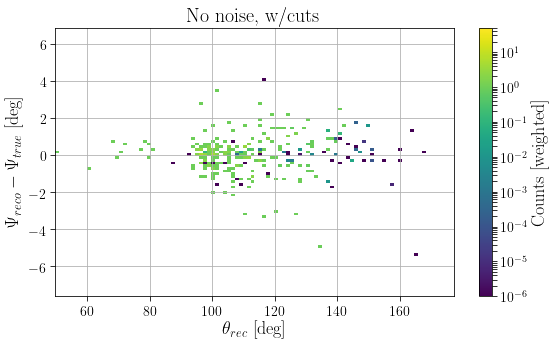

In [26]:
plt.figure(figsize=(8,5))
plt.hist2d(np.degrees(recoNu.theta_reco),deltaPhi, bins=100, normed=False,norm=mpl.colors.LogNorm(vmin=1E-6,vmax=50),weights=recoNu.weight);
# plt.title("No noise, no cuts")
plt.title("No noise, w/cuts")
# plt.hist2d(angle_Stokes,angle_Stokes-angle_true)
plt.grid()
plt.colorbar(label="Counts [weighted]")
plt.xlabel("$\\theta_{rec}$ [deg]")
plt.ylabel("$\Psi_{reco}-\Psi_{true}$ [deg]")
# plt.title("$10^{21}$ eV neutrinos")
plt.tight_layout()
# plt.xlim(0,90)
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_noCuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsTrue_AraSim_noiseless_Cuts.pdf')
# plt.savefig(my_path_plots+'/Dumpster/deltaMCvsReco_AraSim_noiseless_noCuts.png', dpi=150)

-0.0013225291319571481

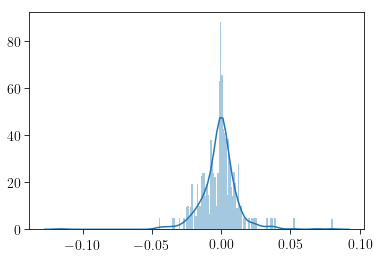

In [27]:
sns.distplot(abs(Py_true)-abs(Py_reco),hist_kws={'weights': recoNu.weight}, bins = 200);
(abs(Py_true)-abs(Py_reco)).mean()

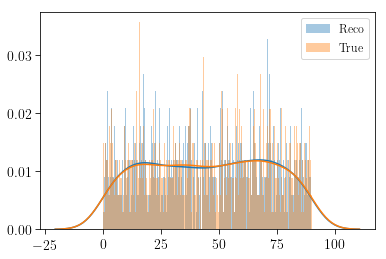

In [335]:
# Pz_true = Pz_true[Pz_true<0]
sns.distplot(phiPol_reco, bins=200, label = "Reco");
sns.distplot(phiPol_true, bins=200, label = "True");
plt.legend()

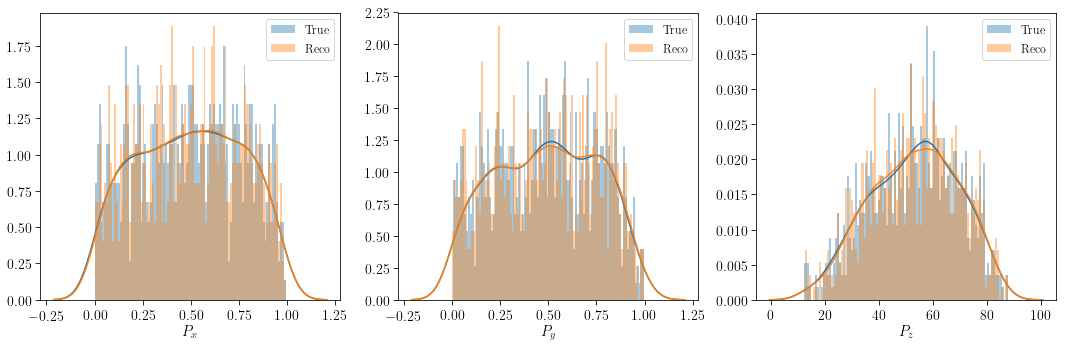

In [336]:
# fig, (ax1, ax2, ax3) = plt.subplots(1, 3,figsize=(15,5))
f, axes = plt.subplots(1, 3, figsize=(15, 5))

sns.distplot(abs(Px_true), bins=100, label= "True", ax=axes[0]);
sns.distplot(abs(Px_reco), bins=100, label= "Reco", ax=axes[0]);
axes[0].set_xlabel("$P_x$", fontsize=15)
# sns.legend()
axes[0].legend()

sns.distplot(abs(Py_true), bins=100, label= "True", ax=axes[1]);
sns.distplot(abs(Py_reco), bins=100, label= "Reco", ax=axes[1]);
axes[1].set_xlabel("$P_y$", fontsize=15)
# sns.legend()
axes[1].legend()

sns.distplot(np.degrees(np.arccos(abs(Pz_true))), bins=100, label= "True", ax=axes[2]);
sns.distplot(np.degrees(np.arccos(abs(Pz_reco))), bins=100,label= "Reco", ax=axes[2]);
axes[2].set_xlabel("$P_z$", fontsize=15)
axes[2].legend()

plt.tight_layout()
# plt.savefig(my_path_plots+'/Dumpster/recoVsTrue_PxPyPz.png', dpi=150)


In [7]:
def makeInputFile(posnu_x, posnu_y, posnu_z, nnu_x, nnu_y, nnu_z, nuflavorint, nu_nubar, pnu, currentint, elast_y):
    """
    Make input file to be read by AraSim (only works if using A2). It's very rudimentary, but it works.
    Author: Jorge Torres, Dec 3.
    Parameters
    ----------
    All the inputs are given in AraSim output coordinates/units.
    Returns
    -------
    Prints something that can be copied and pasted as an input file.
    """
    #posnu
    posNu = np.array([posnu_x, posnu_y, posnu_z])
    avgVec = np.array([10000.83568, 9998.89765, 6359452.44702])
    posNu2 = posNu-avgVec #AraSim adds avgVec when transforming coordinates, and this is what AraSim outputs
    norm = np.linalg.norm(posNu2)
    posNu2 = posNu2/norm#Normalize
    posnu_r = norm
    
    posnu_theta = np.pi/2-np.arccos(posNu2[2])
    posnu_phi = np.arctan2(posNu2[1],posNu2[0])%(2*np.pi)

    #nnu
    nnu = np.array([nnu_x, nnu_y, nnu_z])
    nnu_phi = np.arctan2(nnu[1],nnu[0])%(2*np.pi)
    nnu_theta = np.arccos(nnu[2])
    print("//VERSION=0.1\n//EVENT_NUM=" + str(1) + 
          "\n//evid nuflavorint nu_nubar pnu currentint posnu_r posnu_theta posnu_phi nnu_theta nnu_phi elast_y")
    print("{:08d} {:01d} {:01d} {:.3f} {:01d} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f} {:.4f}\n".format(1, 
        int(nuflavorint), int(nu_nubar), pnu, int(currentint), posnu_r, posnu_theta, posnu_phi, nnu_theta, nnu_phi, elast_y))

In [8]:
makeInputFile(9460.743495817745, 6246.586509661192, 6358358.002140628,0.7964083029166956, 0.5616651540768034, -0.22420095838606358,2,0,20,1,0.047660)

//VERSION=0.1
//EVENT_NUM=1
//evid nuflavorint nu_nubar pnu currentint posnu_r posnu_theta posnu_phi nnu_theta nnu_phi elast_y
00000001 2 0 20.000 1 3945.8013 -0.2811 4.5694 1.7969 0.6142 0.0477



In [5]:
recoNu.loc[recoNu.delta<-15]

EvNum  theta_reco  phi_reco  \
323  73038.0    1.776604  4.568235   

                                               PolTrue  \
323  [-0.8740758825379836, 0.02453443004291761, 0.4...   

                                               PolReco        rmsV  \
323  [-0.6698420104194155, -0.05890378548774766, 0....  466.435779   

           rmsH         maxV         maxH        powerV  ...  energyArr  \
323  353.020693  4327.320285 -3864.906766  2.931683e+07  ...       20.0   

     batch    weight  view_ang  \
323      1  0.979424  0.951819   

                                              PolReco2    R_True    R_Reco  \
323  [-0.6698420104194155, -0.05890378548774766, 0....  1.752388  0.865513   

          dotProd     delta  deltaPhi  
323 -1.319632e-09 -18.72177   3.41767  

[1 rows x 21 columns]

### Plot of event and strings

In [78]:
from mpl_toolkits.mplot3d import Axes3D
A2 = pd.read_csv("./data/ARA_station2.txt")
A2.channel = A2.channel-1
A2 = A2.sort_values(by="channel")
A2

x         y        z  channel
14  10010.60  10002.30 -170.247        0
2   10004.90   9989.60 -170.347        1
6    9997.42  10009.40 -171.589        2
10   9992.16   9995.94 -175.377        3
12  10010.60  10002.30 -189.502        4
0   10004.90   9989.60 -189.400        5
4    9997.42  10009.40 -191.242        6
8    9992.16   9995.94 -194.266        7
15  10010.60  10002.30 -167.492        8
3   10004.90   9989.60 -167.428        9
7    9997.42  10009.40 -168.468       10
11   9992.16   9995.94 -172.420       11
13  10010.60  10002.30 -186.546       12
1   10004.90   9989.60 -186.115       13
5    9997.42  10009.40 -187.522       14
9    9992.16   9995.94 -190.981       15

In [114]:
posNu = np.array([9322.279655032882+600, 8688.995562856462+600, 6359252.976762518-6359452.44702])
# avgVec = np.array([10000.83568, 9998.89765, 6359452.44702])

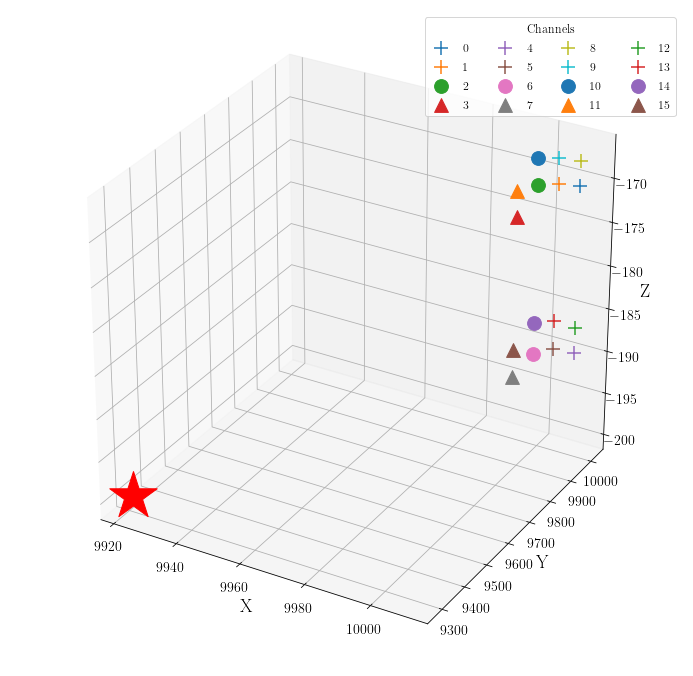

In [190]:
import matplotlib
s = [u'+', u'+', u'o',"^"]*4

fig = plt.figure(figsize=(12,12))
c = np.array(A2.channel)
ax = fig.add_subplot(111, projection='3d')
for _s, i in zip(s, A2.itertuples()):
    ax.scatter(i.x,i.y,i.z,marker=_s,s=190,label="%s"%i.channel)
ax.scatter(posNu[0],posNu[1],posNu[2],marker="*",s=2490, c="red")
# scatter=ax.scatter(A2.x,A2.y,A2.z,c=c,marker="^",s=190)

ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.legend(ncol=4, title="Channels")

In [226]:
Att = pd.read_csv("./data/AttenFac.txt")
Att = Att.sort_values(by="ch")

In [227]:
# for j in range(len(Att)+1):
#     print("%s\t"%Att.columns[j],end =" ")
    
for i in Att.itertuples():
    print("%i\t%e\t %e \t %e \t %e \t %e"%(i.ch,i.factor,i.R, i.IceAttenFactor, i.mag, i.fresnel))

0	5.935541e-04	 4.705016e+02 	 7.541417e-01 	 3.703125e-01 	 1.000000e+00
2	6.260283e-04	 4.855374e+02 	 7.475335e-01 	 4.066174e-01 	 1.000000e+00
4	3.989858e-04	 4.730395e+02 	 7.491896e-01 	 2.519203e-01 	 1.000000e+00
5	4.233212e-04	 4.702367e+02 	 7.504354e-01 	 2.652609e-01 	 1.000000e+00
6	2.963256e-04	 4.880328e+02 	 7.423891e-01 	 1.947989e-01 	 1.000000e+00
7	4.220206e-04	 4.849943e+02 	 7.431582e-01 	 2.754159e-01 	 1.000000e+00
8	6.608277e-04	 4.702140e+02 	 7.549023e-01 	 4.116167e-01 	 1.000000e+00
10	6.926771e-04	 4.852289e+02 	 7.484366e-01 	 4.490787e-01 	 1.000000e+00
12	2.970438e-04	 4.725862e+02 	 7.499250e-01 	 1.871905e-01 	 1.000000e+00
13	3.154521e-04	 4.697318e+02 	 7.512426e-01 	 1.972437e-01 	 1.000000e+00
14	7.174316e-05	 4.874833e+02 	 7.433245e-01 	 4.705023e-02 	 1.000000e+00
15	3.277275e-04	 4.844774e+02 	 7.439599e-01 	 2.134209e-01 	 1.000000e+00


In [183]:
angle = pd.read_csv("./data/viewAngle.txt")
angle = angle.sort_values(by="ch")
for i in Att.itertuples():
    print("Ch: %i, viewangle:%0.3f deg"%(i.ch,np.degrees(i.ViewAngle)))

Ch: 0, viewangle:59.795 deg
Ch: 1, viewangle:59.740 deg
Ch: 2, viewangle:59.372 deg
Ch: 3, viewangle:58.882 deg
Ch: 4, viewangle:58.200 deg
Ch: 5, viewangle:58.219 deg
Ch: 6, viewangle:57.771 deg
Ch: 7, viewangle:57.613 deg
Ch: 8, viewangle:60.099 deg
Ch: 9, viewangle:59.883 deg
Ch: 10, viewangle:59.705 deg
Ch: 11, viewangle:59.267 deg
Ch: 12, viewangle:58.350 deg
Ch: 13, viewangle:58.452 deg
Ch: 14, viewangle:57.995 deg
Ch: 15, viewangle:57.828 deg
